# Navigation

Train agent to navigate 3d space and collect yellow bananas

### Load libraries and start the environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name='Banana.exe', worker_id=2)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


**NOTE**: The task is episodic, and in order to solve the environment, your agent must get an average score of +13 over 100 consecutive episodes.

### Train Agent

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from Agent import Agent

In [7]:
agent = Agent(int(1e6), state_size, action_size)

In [8]:
N_EPISODES = 2000
EPSILON_DECAY = 0.998
MIN_EPSILON = 0.01

epsilon = 1.
total_scores = []

episodes_bar = tqdm(total=N_EPISODES, desc='Episodes')
step_bar = tqdm(total=300, desc='Steps', leave=False)
for i_episode in range(N_EPISODES):
   # Reset environment and get initial state
   env_info = env.reset(train_mode=True)[brain_name]
   state = env_info.vector_observations[0]
   score = 0
   done = False
   
   while not done:
      # Take action
      action = agent.act(state, epsilon)
      
      # Get information from environment
      env_info = env.step(action)[brain_name]
      next_state = env_info.vector_observations[0]
      reward = env_info.rewards[0]
      done = env_info.local_done[0]
      
      # Take a step
      agent.step(state, action, reward, next_state, done)
      
      # Prepare for next action and save score
      state = next_state
      score += reward
      step_bar.update(1)

   step_bar.reset()
         
   total_scores.append(score)
   epsilon = max(MIN_EPSILON, epsilon*EPSILON_DECAY)
   if len(total_scores) > 100 and i_episode % 100 == 0:
      average_score = np.mean(total_scores[-100:])
      print(f'Episode {i_episode}/{N_EPISODES}. | Average Score: {average_score}.')
      if average_score >= 13.:
         print('Environment solved in {i_episode}!')
         torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
         break
         
   episodes_bar.update(1)
step_bar.close()
episodes_bar.close()

Episode 100/2000. | Average Score: 0.31.
Episode 200/2000. | Average Score: 1.34.
Episode 300/2000. | Average Score: 3.26.
Episode 400/2000. | Average Score: 4.48.
Episode 500/2000. | Average Score: 6.12.
Episode 600/2000. | Average Score: 7.48.
Episode 700/2000. | Average Score: 10.06.
Episode 800/2000. | Average Score: 9.95.
Episode 900/2000. | Average Score: 11.28.
Episode 1000/2000. | Average Score: 12.0.
Episode 1100/2000. | Average Score: 12.42.
Episode 1200/2000. | Average Score: 12.79.
Episode 1300/2000. | Average Score: 12.82.
Episode 1400/2000. | Average Score: 13.22.
Environment solved in {i_episode}!


NameError: name 'torch' is not defined

In [10]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

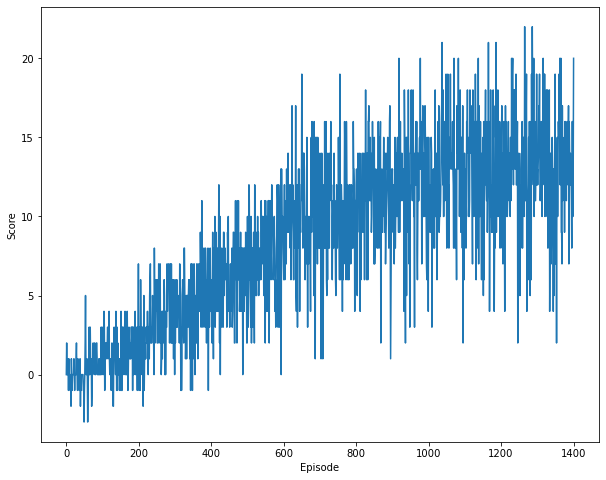

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(total_scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

# Test Agent

In [16]:
agent = Agent(int(1e5), state_size, action_size, pretrained_model_path='./checkpoint.pth')

In [17]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
while True:
   action = agent.act(state, eps=0.)
   env_info = env.step(action)[brain_name]
   state = env_info.vector_observations[0]
   reward = env_info.rewards[0]
   done = env_info.local_done[0]
   score += reward
   if done:
      break
      
print("Score: {}".format(score))

Score: 11.0


# Close environment

In [18]:
env.close()